# FOOTBALL HACKATHON


# 0.0. IMPORTS

In [2]:
import pandas                                                      as pd
import seaborn                                                     as sns

from matplotlib                    import pyplot                   as plt
from IPython.core.display          import HTML
import sweetviz                                                    as sv
#import umap.umap_                                                  as umap
import umap


from sklearn                       import ensemble                 as en
from sklearn.metrics               import r2_score
from sklearn.svm                   import SVR

from sklearn                       import model_selection          as ms

from catboost                      import CatBoostRegressor        as cb
from xgboost                       import XGBClassifier 
import lightgbm                                                    as lgb



import warnings

warnings.filterwarnings("ignore")

## 0.1. Helper Functions 

In [3]:
def my_settings():
    %matplotlib inline
    
    # plotly settings
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 8
 
    # notebook settings
    display(HTML('<style>.container{width:100% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', '{:.2f}'.format)
    
    # seaborn settings
    sns.set(rc={'figure.figsize':(25,12)})
    sns.set_theme(style = 'darkgrid', font_scale = 1)

In [4]:
my_settings()

In [5]:
def descriptive_stats(df): 
    # Central Tendency - Mean, Median
    ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
    ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

    # dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
    d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
    d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
    d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
    d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
    d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

    # concatenar
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m




## 0.2. Load Dataset

In [6]:
test_dataset = pd.read_csv(r'../data/raw/test.csv')

In [7]:
test_dataset.head()

,row_id,scout_id,winner,team,competitionId,player_position_1,player_position_2,player_height,player_weight,player_general_var_0,...,team2_defensive_derived_var_10,team2_offensive_derived_var_11,team2_offensive_derived_var_12,team2_offensive_derived_var_13,team2_offensive_derived_var_14,team2_defensive_derived_var_15,team2_offensive_derived_var_16,team2_defensive_derived_var_17,team2_offensive_derived_var_18,team2_offensive_derived_var_19
0,14785,16,draw,team1,7.00,4.00,4.00,0.32,0.44,0.00,...,0.27,0.19,0.31,0.63,0.41,0.31,0.11,0.45,0.30,0.33
1,15125,2,draw,team1,9.00,11.00,11.00,0.56,0.60,0.00,...,0.35,0.20,0.25,0.54,0.49,0.49,0.11,0.50,0.38,0.50
2,13095,16,loser,team2,10.00,19.00,19.00,0.20,0.30,0.00,...,0.35,0.18,0.26,0.65,0.57,0.49,0.06,0.25,0.59,0.27
3,6079,16,loser,team1,11.00,3.00,9.00,0.34,0.30,0.00,...,0.50,0.31,0.41,0.49,0.59,0.61,0.29,0.32,0.69,0.29
4,16584,11,winner,team1,5.00,4.00,4.00,0.59,0.70,0.20,...,0.40,0.19,0.04,0.84,0.69,0.52,0.09,0.44,0.48,0.44


In [8]:
train_dataset = pd.read_csv(r'../data/raw/train.csv')

In [9]:
submission_dataset = pd.read_csv(r'../data/raw/sample_submission_wBWLI0s.csv')

In [10]:
submission_dataset.head()

,row_id,rating_num
0,14785,7
1,15125,7
2,13095,7
3,6079,7
4,16584,7


In [11]:
df_test_total = pd.merge(test_dataset, submission_dataset , how = 'left' , on = 'row_id' )

In [12]:
df_test_total

,row_id,scout_id,winner,team,competitionId,player_position_1,player_position_2,player_height,player_weight,player_general_var_0,...,team2_offensive_derived_var_11,team2_offensive_derived_var_12,team2_offensive_derived_var_13,team2_offensive_derived_var_14,team2_defensive_derived_var_15,team2_offensive_derived_var_16,team2_defensive_derived_var_17,team2_offensive_derived_var_18,team2_offensive_derived_var_19,rating_num
0,14785,16,draw,team1,7.00,4.00,4.00,0.32,0.44,0.00,...,0.19,0.31,0.63,0.41,0.31,0.11,0.45,0.30,0.33,7
1,15125,2,draw,team1,9.00,11.00,11.00,0.56,0.60,0.00,...,0.20,0.25,0.54,0.49,0.49,0.11,0.50,0.38,0.50,7
2,13095,16,loser,team2,10.00,19.00,19.00,0.20,0.30,0.00,...,0.18,0.26,0.65,0.57,0.49,0.06,0.25,0.59,0.27,7
3,6079,16,loser,team1,11.00,3.00,9.00,0.34,0.30,0.00,...,0.31,0.41,0.49,0.59,0.61,0.29,0.32,0.69,0.29,7
4,16584,11,winner,team1,5.00,4.00,4.00,0.59,0.70,0.20,...,0.19,0.04,0.84,0.69,0.52,0.09,0.44,0.48,0.44,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8769,21259,15,loser,team1,7.00,11.00,11.00,0.46,0.60,0.00,...,0.29,0.34,0.57,0.72,0.68,0.34,0.40,0.55,0.28,7
8770,9371,2,draw,team1,4.00,16.00,16.00,0.34,0.40,0.20,...,0.16,0.17,0.80,0.45,0.44,0.09,0.42,0.44,0.14,7
8771,23226,2,loser,team2,4.00,1.00,1.00,0.44,0.36,0.00,...,0.18,0.31,0.59,0.48,0.80,0.09,0.25,0.36,0.38,7
8772,26623,11,winner,team1,10.00,1.00,1.00,0.46,0.54,0.00,...,0.14,0.23,0.61,0.36,0.33,0.05,0.43,0.50,0.09,7


#  2.0. Description Data

In [13]:
df1 = train_dataset.copy()

In [14]:
df1.head()

,row_id,scout_id,rating_num,winner,team,competitionId,player_position_1,player_position_2,player_height,player_weight,...,team2_defensive_derived_var_10,team2_offensive_derived_var_11,team2_offensive_derived_var_12,team2_offensive_derived_var_13,team2_offensive_derived_var_14,team2_defensive_derived_var_15,team2_offensive_derived_var_16,team2_defensive_derived_var_17,team2_offensive_derived_var_18,team2_offensive_derived_var_19
0,1,13,7.00,winner,team1,8,7.00,7.00,0.32,0.48,...,0.19,0.13,0.10,0.60,0.34,0.35,0.03,0.29,0.31,0.20
1,3,16,6.50,loser,team2,8,3.00,9.00,0.46,0.42,...,0.19,0.17,0.27,0.61,0.53,0.47,0.05,0.33,0.38,0.30
2,4,4,8.50,loser,team1,5,11.00,11.00,0.68,0.44,...,0.31,0.25,0.21,0.56,0.69,0.44,0.22,0.41,0.57,0.44
3,5,13,8.00,loser,team2,4,17.00,17.00,0.68,0.58,...,0.28,0.16,0.21,0.53,0.37,0.53,0.10,0.42,0.33,0.24
4,7,11,3.50,draw,team1,5,10.00,10.00,0.73,0.70,...,0.45,0.20,0.13,0.69,0.68,0.73,0.13,0.45,0.44,0.31


In [15]:
df1.columns

Index(['row_id', 'scout_id', 'rating_num', 'winner', 'team', 'competitionId',
       'player_position_1', 'player_position_2', 'player_height',
       'player_weight',
       ...
       'team2_defensive_derived_var_10', 'team2_offensive_derived_var_11',
       'team2_offensive_derived_var_12', 'team2_offensive_derived_var_13',
       'team2_offensive_derived_var_14', 'team2_defensive_derived_var_15',
       'team2_offensive_derived_var_16', 'team2_defensive_derived_var_17',
       'team2_offensive_derived_var_18', 'team2_offensive_derived_var_19'],
      dtype='object', length=800)

In [16]:
df1.nunique()

row_id                            20453
scout_id                             21
rating_num                           13
winner                                3
team                                  2
                                  ...  
team2_defensive_derived_var_15     2798
team2_offensive_derived_var_16     3624
team2_defensive_derived_var_17     1387
team2_offensive_derived_var_18     3509
team2_offensive_derived_var_19      609
Length: 800, dtype: int64

## 2.1. Dimensions Data

In [17]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 20453
Number of columns: 800


## 2.2. Data Types

In [18]:
df1.dtypes

row_id                              int64
scout_id                            int64
rating_num                        float64
winner                             object
team                               object
                                   ...   
team2_defensive_derived_var_15    float64
team2_offensive_derived_var_16    float64
team2_defensive_derived_var_17    float64
team2_offensive_derived_var_18    float64
team2_offensive_derived_var_19    float64
Length: 800, dtype: object

## 2.3. Check NA

In [19]:
null_cols = df1.columns[df1.isnull().all()]
df1.drop(null_cols, axis = 1, inplace = True)

In [20]:
null_cols

Index(['team1_other_raw_var_19', 'team1_other_raw_var_31',
       'team1_other_raw_var_33', 'team1_other_raw_var_38',
       'team1_other_raw_var_40', 'team1_other_raw_var_43',
       'team1_other_raw_var_50', 'team1_other_raw_var_51',
       'team1_other_raw_var_72', 'team1_other_raw_var_82',
       'team1_other_raw_var_92', 'team1_other_ratio_var_32',
       'team1_other_ratio_var_33', 'team2_other_raw_var_19',
       'team2_other_raw_var_31', 'team2_other_raw_var_33',
       'team2_other_raw_var_38', 'team2_other_raw_var_40',
       'team2_other_raw_var_43', 'team2_other_raw_var_50',
       'team2_other_raw_var_51', 'team2_other_raw_var_72',
       'team2_other_raw_var_82', 'team2_other_raw_var_92',
       'team2_other_ratio_var_32', 'team2_other_ratio_var_33'],
      dtype='object')

In [21]:
df1.isna().sum()

row_id                               0
scout_id                             0
rating_num                           0
winner                               0
team                                 0
                                  ... 
team2_defensive_derived_var_15    1427
team2_offensive_derived_var_16    1427
team2_defensive_derived_var_17    1427
team2_offensive_derived_var_18    1427
team2_offensive_derived_var_19    1427
Length: 774, dtype: int64

## 2.4. Replace NA

In [22]:
df1 = df1.fillna(0) 
#jdf1.replace(np.nan, 0)


## 2.5. Changes dtypes

## 2.6. Descriptive Statistics

In [23]:
num_attributes = df1.select_dtypes(include=['int64' , 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64' , 'float64'])

###  2.6.1. Numerical Attributs

In [22]:
#correlation = num_attributes.corr(method='pearson')
#sns.heatmap(correlation, annot=True)

KeyboardInterrupt: 

### 2.6.2 Categorical Attributs


KeyError: 'winer'

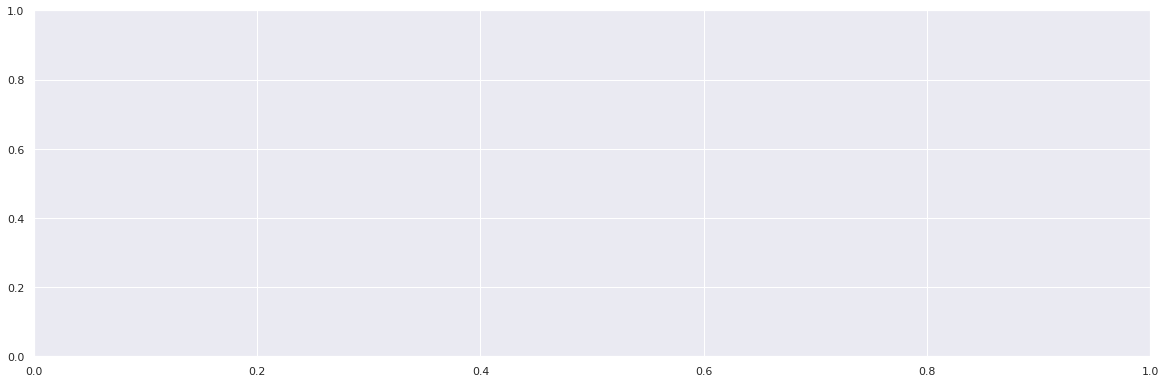

In [44]:
 #Num Attributes plot
plt.figure(figsize=(20,14))

plt.subplot(2,1,1)
age_hist = sns.histplot(df1['winer'], binwidth=1, kde=True);
age_hist.set_ylabel('Customers')
age_hist.set_xlabel('Age')
age_hist.set_title('Customers by Age');

plt.subplot(2,1,2)
hap_hist = sns.histplot(df1['health_annual_paid'], kde=True);
hap_hist.set_ylabel('Customers')
hap_hist.set_xlabel('Health Annual Paid')
hap_hist.set_title('Customers by Health Annual Paid');



# 3.0. Variable Filtering

In [24]:
df2 = df1.copy()

# 4.0. Feature Engeneering

In [25]:
df3 = df2.copy()

In [26]:
df3.head()

,row_id,scout_id,rating_num,winner,team,competitionId,player_position_1,player_position_2,player_height,player_weight,...,team2_defensive_derived_var_10,team2_offensive_derived_var_11,team2_offensive_derived_var_12,team2_offensive_derived_var_13,team2_offensive_derived_var_14,team2_defensive_derived_var_15,team2_offensive_derived_var_16,team2_defensive_derived_var_17,team2_offensive_derived_var_18,team2_offensive_derived_var_19
0,1,13,7.00,winner,team1,8,7.00,7.00,0.32,0.48,...,0.19,0.13,0.10,0.60,0.34,0.35,0.03,0.29,0.31,0.20
1,3,16,6.50,loser,team2,8,3.00,9.00,0.46,0.42,...,0.19,0.17,0.27,0.61,0.53,0.47,0.05,0.33,0.38,0.30
2,4,4,8.50,loser,team1,5,11.00,11.00,0.68,0.44,...,0.31,0.25,0.21,0.56,0.69,0.44,0.22,0.41,0.57,0.44
3,5,13,8.00,loser,team2,4,17.00,17.00,0.68,0.58,...,0.28,0.16,0.21,0.53,0.37,0.53,0.10,0.42,0.33,0.24
4,7,11,3.50,draw,team1,5,10.00,10.00,0.73,0.70,...,0.45,0.20,0.13,0.69,0.68,0.73,0.13,0.45,0.44,0.31


In [27]:
dict_winner = {'winner': 2, 'draw' : 1, 'loser':0}
df3['winner'] = df3['winner'].map(dict_winner)
df3['winner'].value_counts()

2    8735
0    6442
1    5276
Name: winner, dtype: int64

In [28]:
dict_team = {'team1': 1, 'team2':0}
df3['team'] = df3['team'].map(dict_team)
df3['team'].value_counts()

1    10306
0    10147
Name: team, dtype: int64

In [24]:
dict_winner_t = {'winner': 2, 'draw' : 1, 'loser':0}
df_test_total['winner'] = df_test_total['winner'].map(dict_winner_t)
df_test_total['winner'].value_counts()

2    3258
0    3236
1    2280
Name: winner, dtype: int64

In [25]:
dict_team_t = {'team1': 1, 'team2':0}
df_test_total['team'] = df_test_total['team'].map(dict_team_t)
df_test_total['team'].value_counts()

1.00    4563
0.00    4210
Name: team, dtype: int64

## 4.1. Feature Creation

# 5.0. EDA (Exploratory Data Analysis)

In [29]:
df4 = df3.copy()

In [52]:
# Generate report
report = sv.analyze(df4, target_feat='rating_num')

# Save and show on browser
report.show_html(filepath='../reports/sweetviz_report.html',open_browser=True)
#Report ../reports/sweetviz_report.html was generated.

[Summarizing dataframe]                      |                                          | [  0%]   00:00 -> (05:16 left)

PAIRWISE CALCULATION LENGTH WARNING: There are 800 features in this dataframe and the 'pairwise_analysis' parameter is set to 'auto'.
Pairwise analysis is exponential in length: 800 features will cause ~640000 pairs to be evaluated, which could take a long time.

You must call the function with the parameter pairwise_analysis='on' or 'off' to explicitly select desired behavior.


AttributeError: 'DataframeReport' object has no attribute 'associations_html_source'

# Univariable 

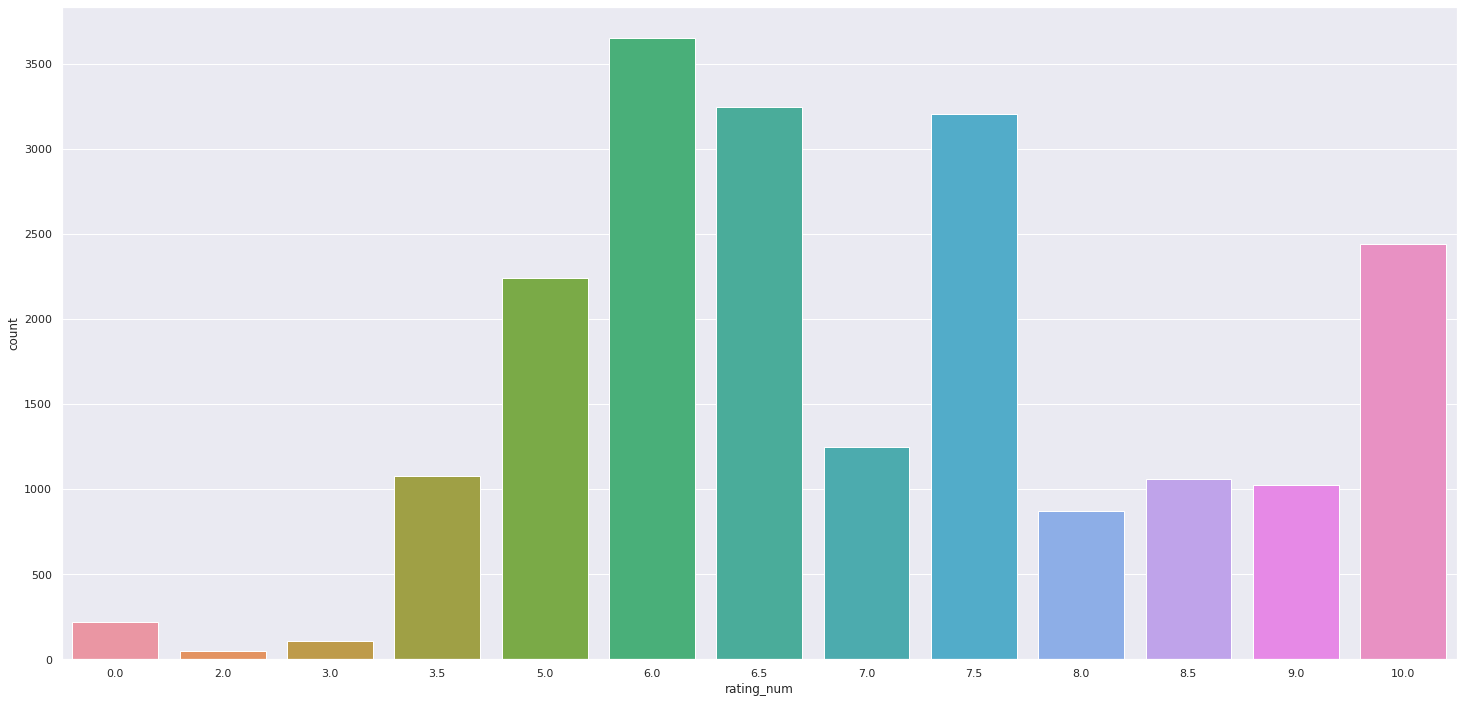

In [53]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="rating_num", data=df4)

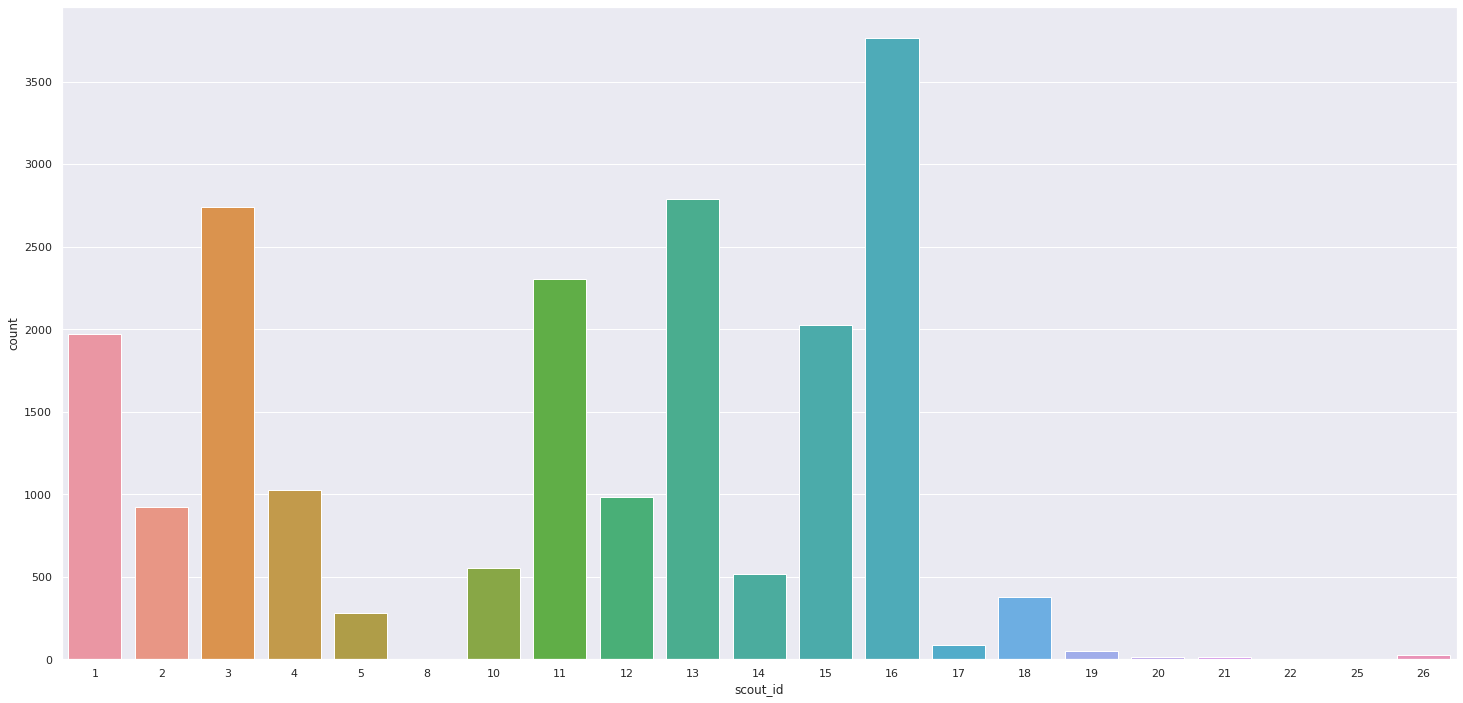

In [54]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="scout_id", data=df4)

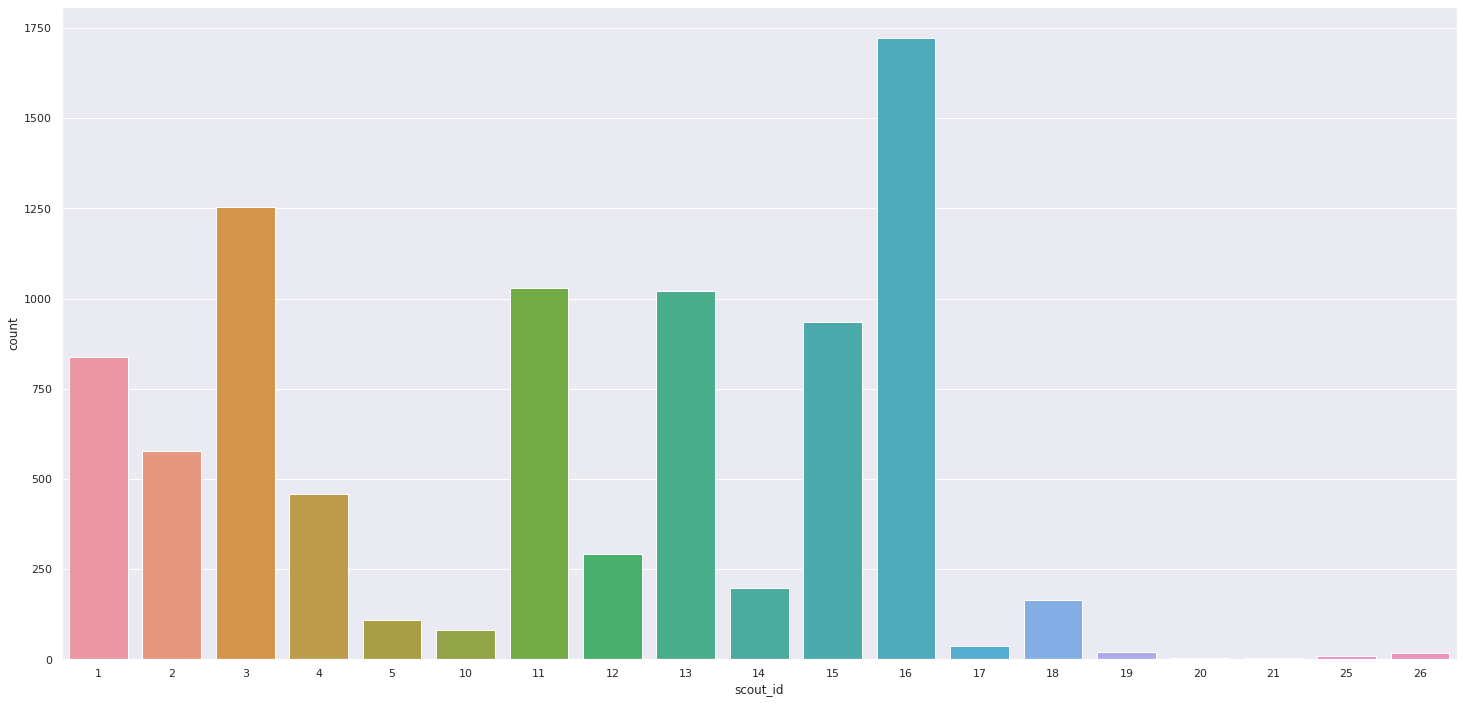

In [55]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="scout_id", data=df_test_total)

[ 8  5  4  7  9 10  6 11 14 15]


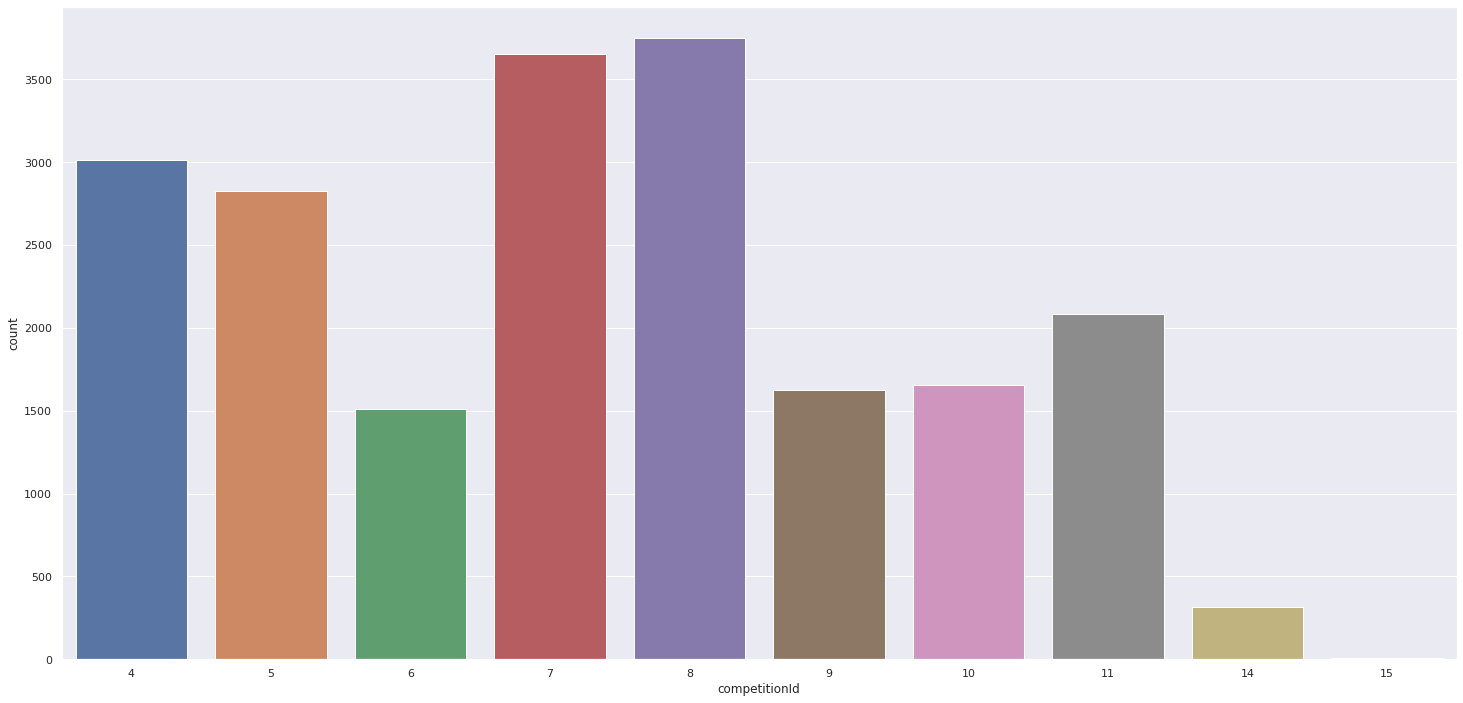

In [56]:
print(df4.competitionId.unique())
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="competitionId", data=df4)

[ 7.  9. 10. 11.  5.  6.  4.  8. 15. 14. nan]


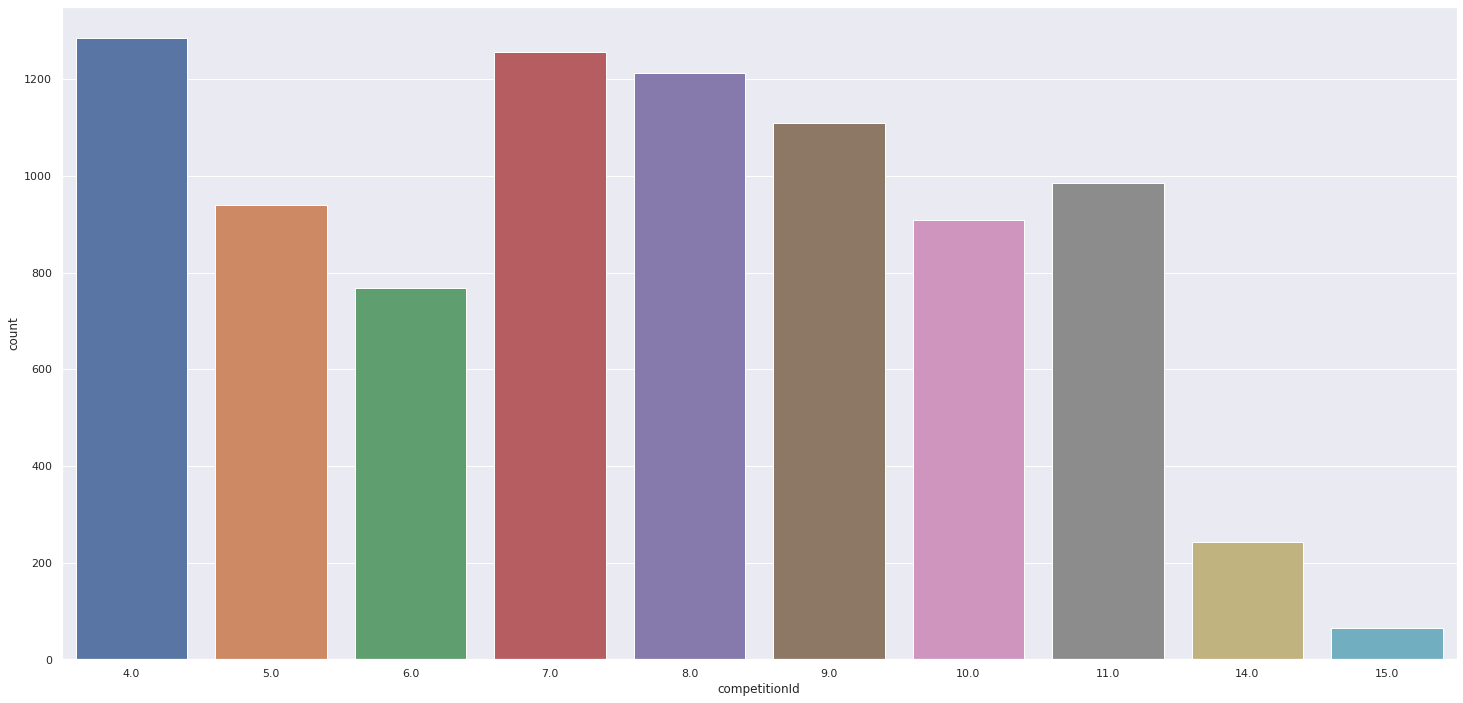

In [57]:
print(df_test_total.competitionId.unique())
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="competitionId", data=df_test_total)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 22.0, 23.0]


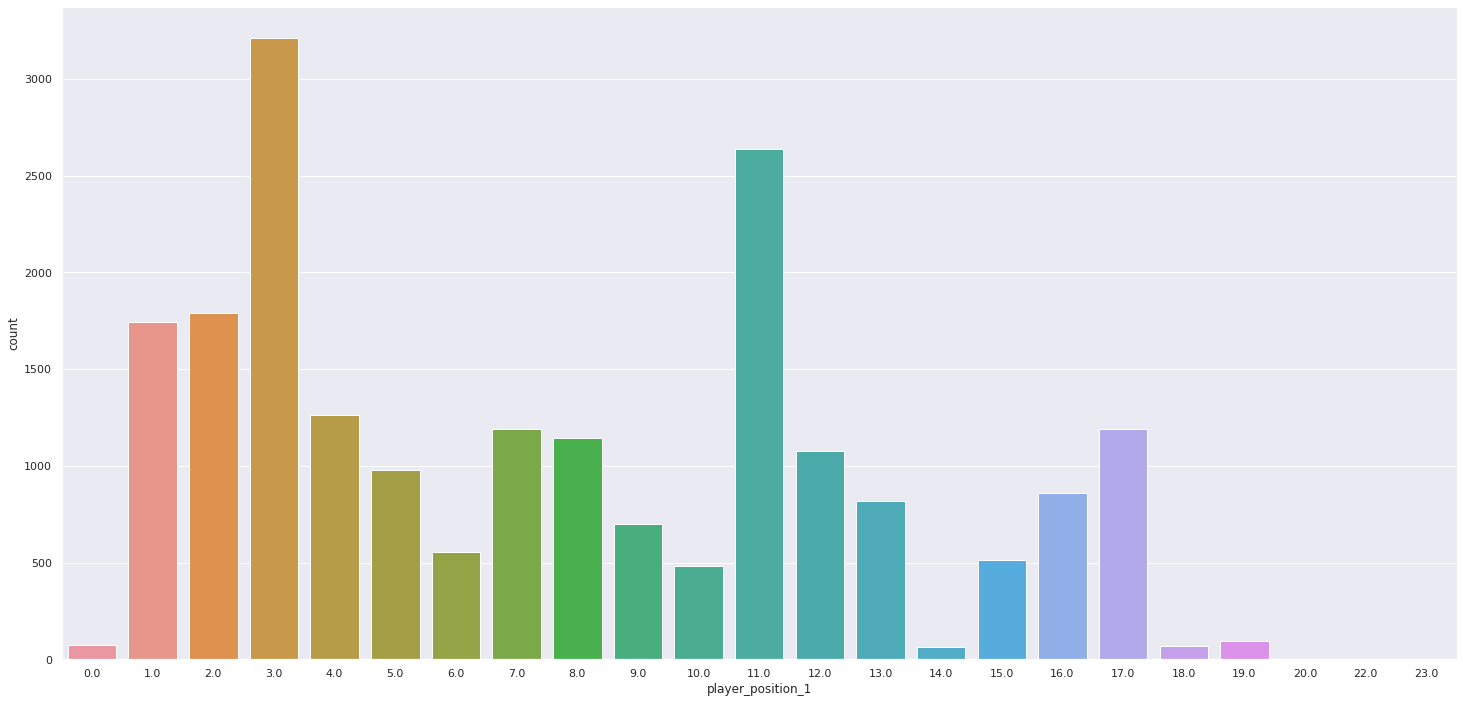

In [58]:
print(sorted(df4.player_position_1.unique()))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="player_position_1", data=df4)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, nan, 20.0, 21.0, 23.0]


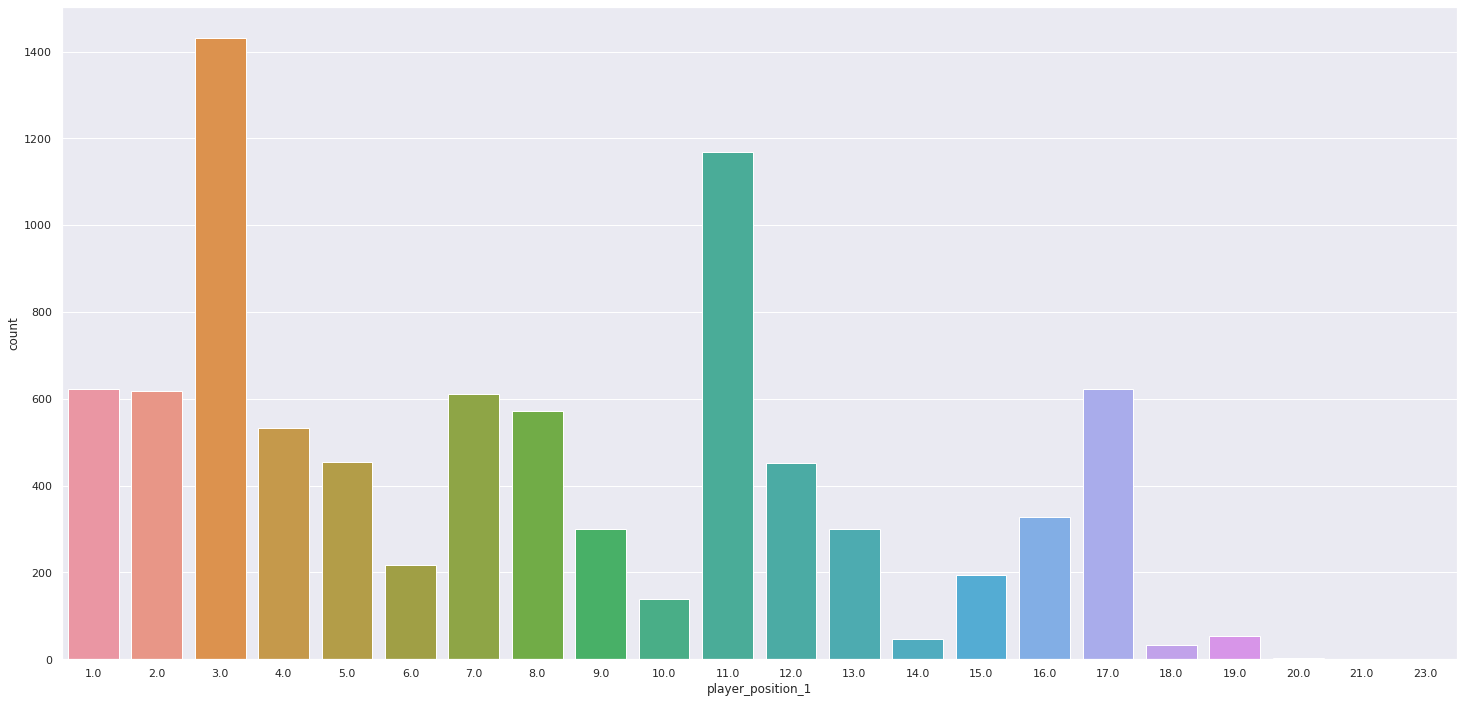

In [59]:
print(sorted(df_test_total.player_position_1.unique()))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="player_position_1", data=df_test_total)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 22.0, 23.0]


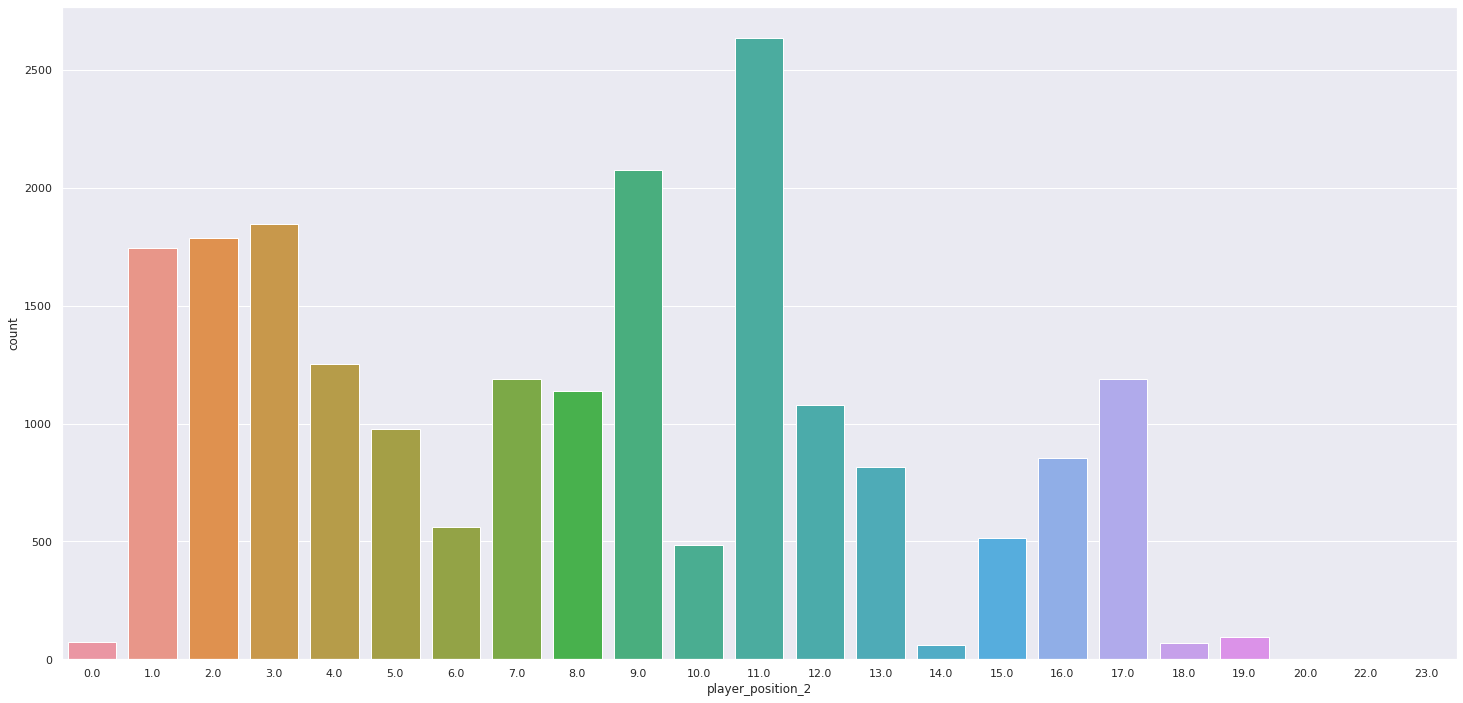

In [60]:
print(sorted(df4.player_position_2.unique()))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="player_position_2", data=df4)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, nan, 20.0, 21.0, 23.0]


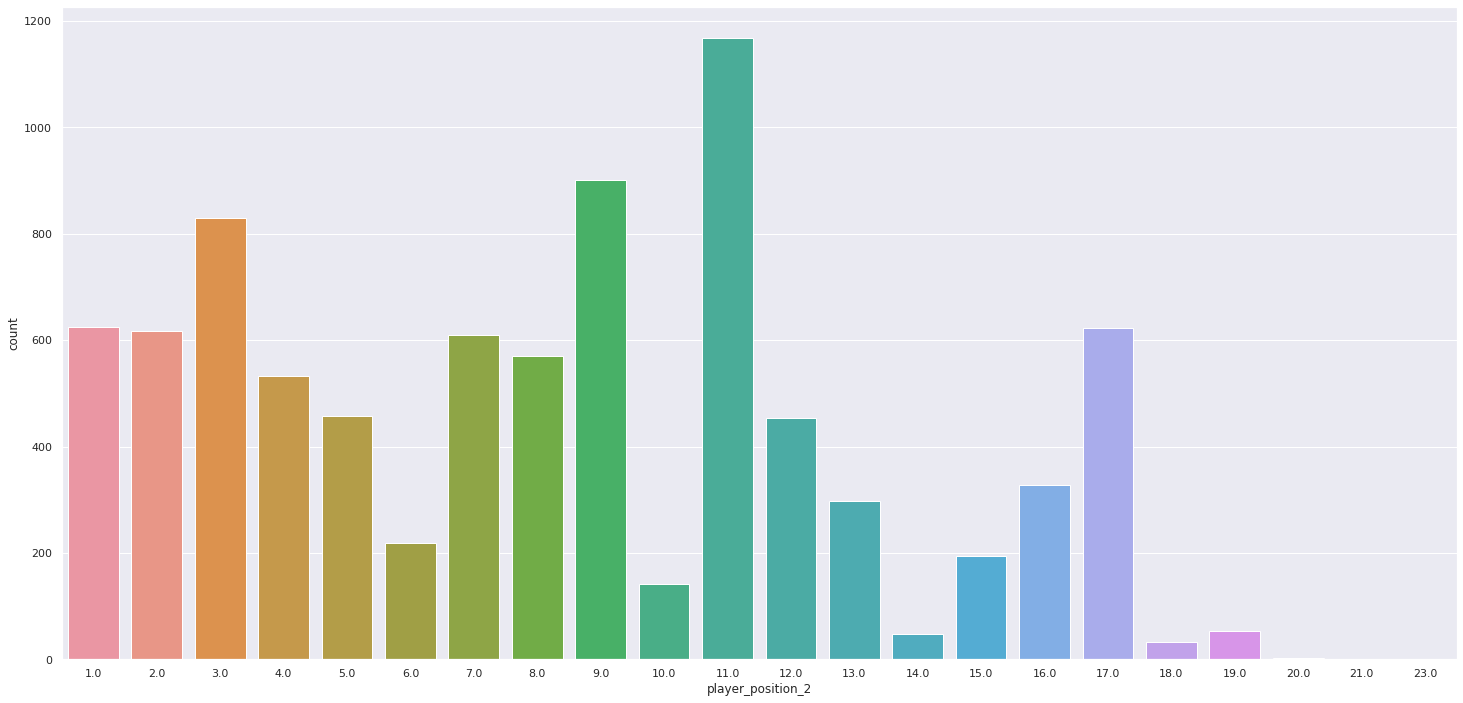

In [61]:
print(sorted(df_test_total.player_position_2.unique()))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="player_position_2", data=df_test_total)

<AxesSubplot:xlabel='player_height', ylabel='Count'>

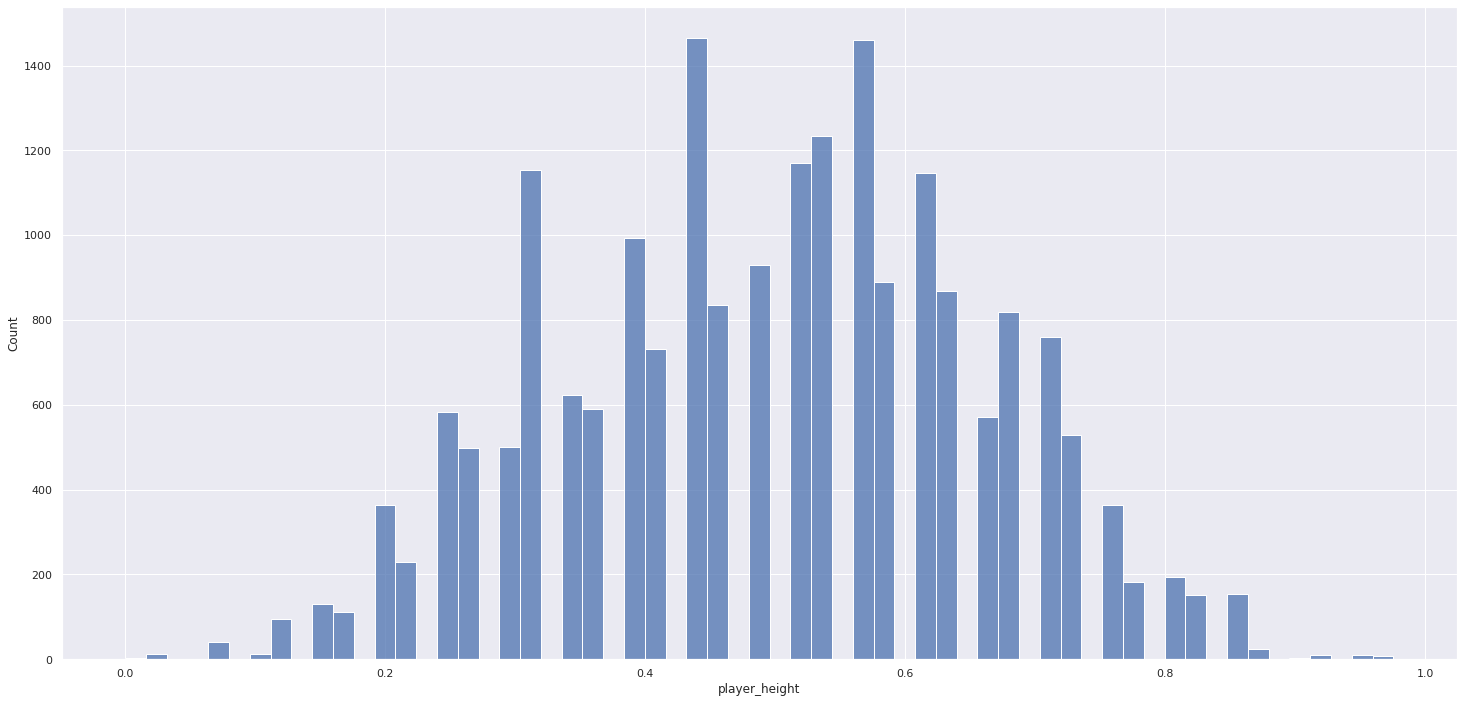

In [62]:
sns.histplot(data=df4, x="player_height")

<AxesSubplot:xlabel='player_height', ylabel='Count'>

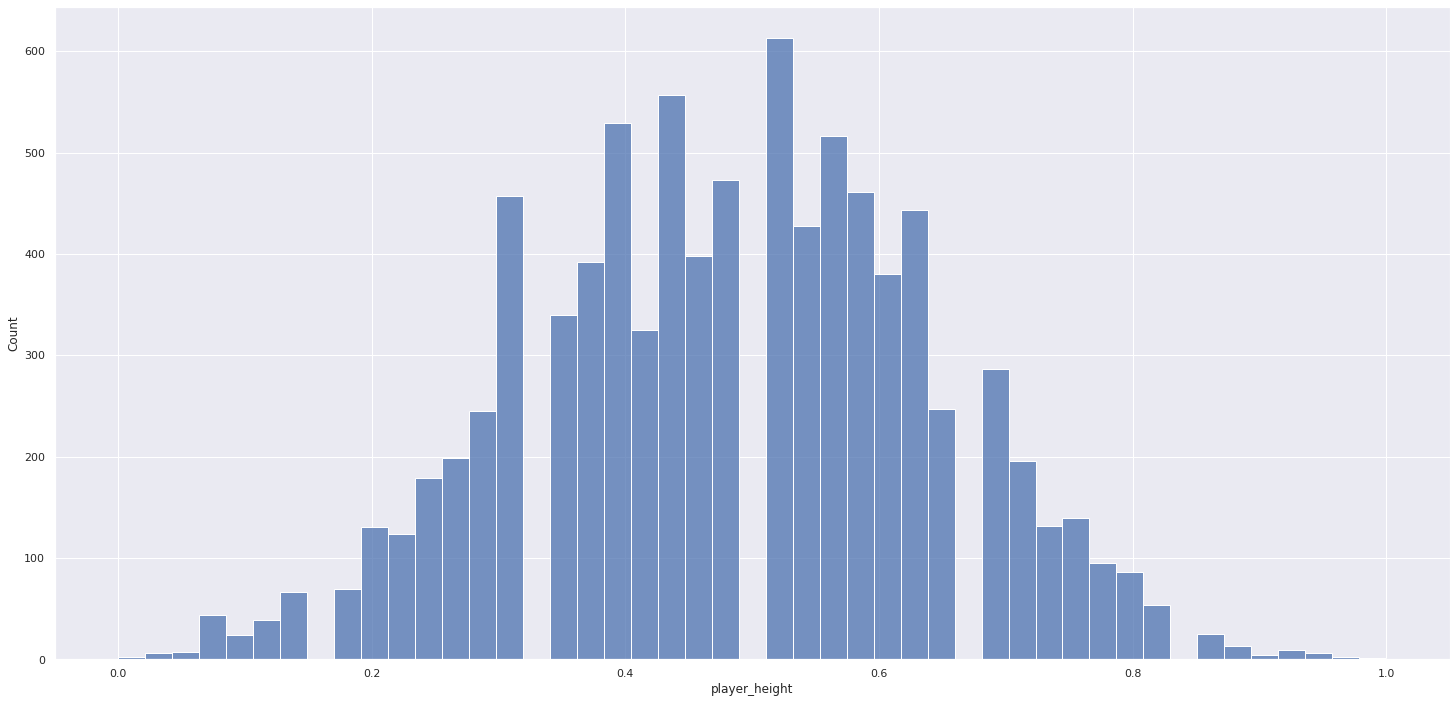

In [63]:
sns.histplot(data=df_test_total, x="player_height")

# 6.0. Data Preparation

In [30]:
df5 = df4.copy()

# 7.0. Feature Selection

In [31]:
df6 = df5.copy()

In [32]:
nomes = list(df6)

In [33]:
nomes.remove('rating_num')

In [59]:
y.shape

(20453,)

### Validation Split

In [34]:
X = df6.drop(['rating_num'], axis = 1)
y = df6['rating_num']

#Split Train into Val:
x_train, x_val, y_train, y_val = ms.train_test_split(X, y, stratify = y, test_size=0.10, random_state = 45)

In [35]:
# model definition
forest = lgb.LGBMRegressor(n_estimators=300, random_state=0, n_jobs=-1)

# data preparation
x_train_n = x_train 
y_train_n = y_train.values 
forest.fit( x_train_n, y_train_n )

LGBMRegressor(n_estimators=300, random_state=0)

Feature ranking: 
                             feature  importances
0                           scout_id          159
0                             row_id          134
0                      player_weight          133
0               player_general_var_4          125
0                      player_height          110
..                               ...          ...
0    player_physical_derived_var_106            0
0    player_physical_derived_var_105            0
0   player_defensive_derived_var_103            0
0   player_defensive_derived_var_102            0
0           player_other_raw_var_149            0

[773 rows x 2 columns]


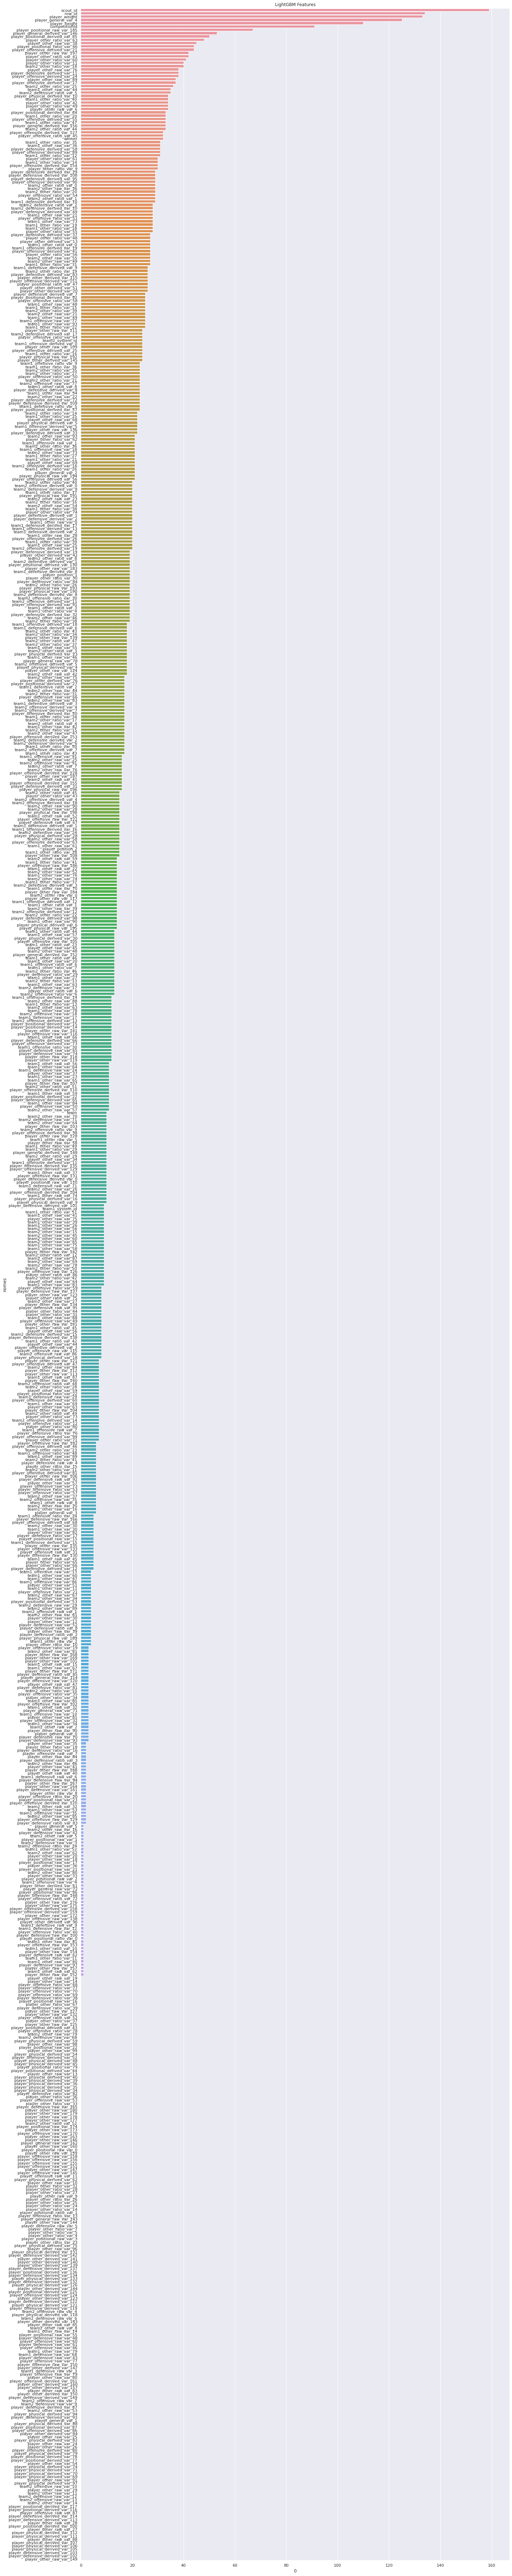

In [36]:
importances = forest.feature_importances_

# Print the feature ranking
print('Feature ranking: ')
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importances': j}, index=[0])
    df = pd.concat([df,aux], axis = 0)
    
print(df.sort_values('importances', ascending= False))
    
# Plot tge umpurity-based feature importances of the forest

df_ft = pd.DataFrame(np.array(importances))
df_ft['nomes'] = nomes
list(df_ft)
plt.figure(figsize=(20, 100))
sns.barplot(x=0, y="nomes", data=df_ft.sort_values(by= 0 ,ascending=False))
plt.title('LightGBM Features')

plt.tight_layout()
plt.show()



In [37]:
df

,feature,importances
0,row_id,134
0,scout_id,159
0,winner,32
0,team,10
0,competitionId,91
...,...,...
0,team2_defensive_derived_var_15,8
0,team2_offensive_derived_var_16,21
0,team2_defensive_derived_var_17,24
0,team2_offensive_derived_var_18,15


In [38]:
best_columns = df[(df['importances'] >= 30) ]

In [39]:
bc_2 = list(best_columns['feature'])

In [40]:
bc_2

['row_id',
 'scout_id',
 'winner',
 'competitionId',
 'player_height',
 'player_weight',
 'player_general_var_4',
 'player_other_raw_var_6',
 'player_other_raw_var_38',
 'player_other_raw_var_76',
 'player_other_raw_var_89',
 'player_positional_raw_var_185',
 'player_other_raw_var_197',
 'player_other_ratio_var_9',
 'player_other_ratio_var_11',
 'player_other_ratio_var_41',
 'player_other_ratio_var_42',
 'player_offensive_ratio_var_45',
 'player_positional_ratio_var_46',
 'player_other_ratio_var_49',
 'player_other_ratio_var_60',
 'player_other_ratio_var_61',
 'player_other_ratio_var_63',
 'player_physical_derived_var_10',
 'player_defensive_derived_var_11',
 'player_offensive_derived_var_17',
 'player_offensive_derived_var_21',
 'player_offensive_derived_var_24',
 'player_offensive_derived_var_55',
 'player_defensive_derived_var_58',
 'player_positional_derived_var_64',
 'player_positional_derived_var_85',
 'player_offensive_derived_var_89',
 'player_offensive_derived_var_127',
 'play

In [41]:
df_new = df6[['row_id','scout_id','winner','competitionId','player_height','player_weight','player_general_var_4','player_other_raw_var_6','player_other_raw_var_38','player_other_raw_var_76',
'player_other_raw_var_89','player_positional_raw_var_185','player_other_raw_var_197','player_other_ratio_var_9',
'player_other_ratio_var_11','player_other_ratio_var_41','player_other_ratio_var_42','player_offensive_ratio_var_45',
'player_positional_ratio_var_46','player_other_ratio_var_49','player_other_ratio_var_60','player_other_ratio_var_61',
'player_other_ratio_var_63','player_physical_derived_var_10','player_defensive_derived_var_11','player_offensive_derived_var_17',
'player_offensive_derived_var_21','player_offensive_derived_var_24','player_offensive_derived_var_55','player_defensive_derived_var_58',
'player_positional_derived_var_64','player_positional_derived_var_85','player_offensive_derived_var_89','player_offensive_derived_var_127',
'player_general_derived_var_146','player_offensive_derived_var_154','player_general_derived_var_156','team1_other_raw_var_36','team1_other_raw_var_44',
'team1_other_ratio_var_12','team1_other_ratio_var_14','team1_other_ratio_var_20','team1_other_ratio_var_35','team1_other_ratio_var_40','team1_other_ratio_var_47',
'team2_defensive_ratio_var_5','team2_other_ratio_var_18','team2_other_ratio_var_25','team2_other_ratio_var_44']]

In [42]:
df_new.head()

,row_id,scout_id,winner,competitionId,player_height,player_weight,player_general_var_4,player_other_raw_var_6,player_other_raw_var_38,player_other_raw_var_76,...,team1_other_ratio_var_12,team1_other_ratio_var_14,team1_other_ratio_var_20,team1_other_ratio_var_35,team1_other_ratio_var_40,team1_other_ratio_var_47,team2_defensive_ratio_var_5,team2_other_ratio_var_18,team2_other_ratio_var_25,team2_other_ratio_var_44
0,1,13,2,8,0.32,0.48,0.11,0.47,0.29,0.00,...,0.84,0.14,0.41,0.28,0.45,0.33,0.37,0.50,0.27,0.20
1,3,16,0,8,0.46,0.42,0.08,0.44,0.00,0.38,...,0.80,0.05,0.32,0.58,0.59,0.20,0.43,0.56,0.33,0.57
2,4,4,0,5,0.68,0.44,0.07,0.63,0.12,0.38,...,0.79,0.16,0.45,0.32,0.18,0.38,0.54,0.44,0.16,0.50
3,5,13,0,4,0.68,0.58,0.00,0.47,0.00,0.25,...,0.78,0.04,0.49,0.59,0.58,0.29,0.45,0.66,0.24,0.33
4,7,11,1,5,0.73,0.70,0.26,0.47,0.00,0.12,...,0.77,0.09,0.32,0.49,0.55,0.20,0.22,0.37,0.35,0.44


In [52]:
X_val = x_val[['row_id','scout_id','winner','competitionId','player_height','player_weight','player_general_var_4','player_other_raw_var_6','player_other_raw_var_38','player_other_raw_var_76',
'player_other_raw_var_89','player_positional_raw_var_185','player_other_raw_var_197','player_other_ratio_var_9',
'player_other_ratio_var_11','player_other_ratio_var_41','player_other_ratio_var_42','player_offensive_ratio_var_45',
'player_positional_ratio_var_46','player_other_ratio_var_49','player_other_ratio_var_60','player_other_ratio_var_61',
'player_other_ratio_var_63','player_physical_derived_var_10','player_defensive_derived_var_11','player_offensive_derived_var_17',
'player_offensive_derived_var_21','player_offensive_derived_var_24','player_offensive_derived_var_55','player_defensive_derived_var_58',
'player_positional_derived_var_64','player_positional_derived_var_85','player_offensive_derived_var_89','player_offensive_derived_var_127',
'player_general_derived_var_146','player_offensive_derived_var_154','player_general_derived_var_156','team1_other_raw_var_36','team1_other_raw_var_44',
'team1_other_ratio_var_12','team1_other_ratio_var_14','team1_other_ratio_var_20','team1_other_ratio_var_35','team1_other_ratio_var_40','team1_other_ratio_var_47',
'team2_defensive_ratio_var_5','team2_other_ratio_var_18','team2_other_ratio_var_25','team2_other_ratio_var_44']]

## 7.2. UMAP

In [43]:
# training dataset 
X = df_new.copy()
Y = df6['rating_num']

# model definition
rf_model = en.RandomForestRegressor(n_estimators = 300 , random_state = 42 , n_jobs=-1)

# model training
rf_model.fit(X,Y)

# dataframe Leaf
df_leaf = pd.DataFrame(rf_model.apply(X))

In [44]:
%%time
# reduzer dimensionality
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(df_leaf)


# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:,0]
df_tree['embedding_y'] = embedding[:,1]



CPU times: user 56.9 s, sys: 2.13 s, total: 59 s
Wall time: 25.3 s


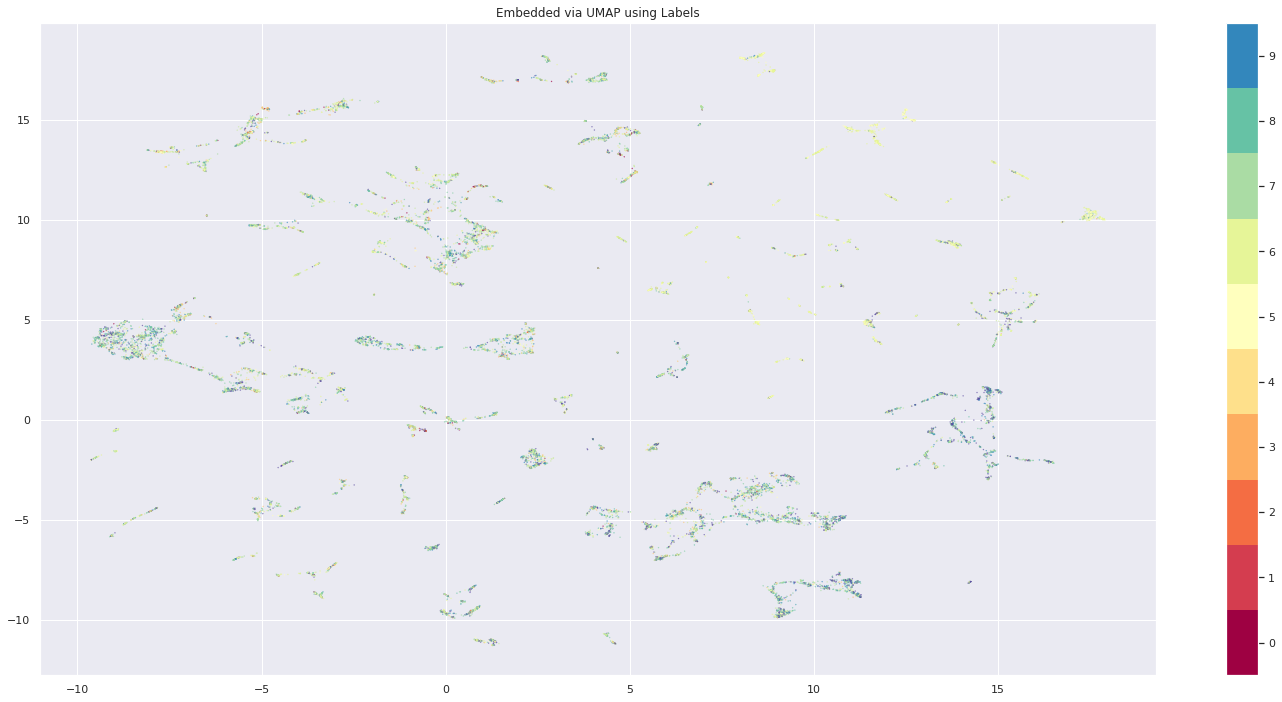

In [45]:
plt.scatter(*embedding.T, s=0.1, c=Y, cmap='Spectral', alpha=1.0)
#plt.scatter(embedding.embedding_[:, 0], embedding.embedding_[:, 1], s= 5, c=Y, cmap='Spectral')
#plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(Y)
plt.title( 'Embedded via UMAP using Labels');

In [53]:
# test dataset 
x_val = X_val.copy()
Y = y_val.copy()

In [ ]:
%%time

# model definition
rf_model = en.RandomForestRegressor(n_estimators = 300 , random_state = 42 , n_jobs=-1)

# model training
rf_model.fit(x_val,x_val)

# dataframe Leaf
df_leaf = pd.DataFrame(rf_model.apply(x_val))

# reduzer dimensionality
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(df_leaf)


# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:,0]
df_tree['embedding_y'] = embedding[:,1]

plt.scatter(*embedding.T, s=0.1, c=Y, cmap='Spectral', alpha=1.0)
#plt.scatter(embedding.embedding_[:, 0], embedding.embedding_[:, 1], s= 5, c=Y, cmap='Spectral')
#plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(Y)
plt.title( 'Embedded via UMAP using Labels');

# 8.0. Hyperparameter Fine-Tunning

In [46]:
df7 = df_tree.copy()

# 9.0. Model Training 

## SVM

In [56]:
X.shape

(20453, 49)

In [57]:
Y.shape

(2046,)

In [54]:
# Model definition
svm = SVR(verbose=False)  

# Model training
svm.fit(X, Y)

# Model predict
yhat_svm = svm.predict(X_val)


ValueError: Found input variables with inconsistent numbers of samples: [20453, 2046]

In [ ]:
# perfomance
result_svc = r2_score(Y_test ,yhat_svm)

## Catboost


In [ ]:
# Model definition
catboost = cb( random_state=42, verbose=False )

# Model training
catboost.fit(df7, Y)

# Model prediction 
yhat_cb = catboost.score( x_val , y_val )



In [ ]:
# perfomance
result_catboost = r2_score(Y_test ,yhat_cb)

## Random Forest Regression

In [ ]:
# model definition
rf_model = en.RandomForestRegressor(n_estimators = 300 , random_state = 42 , n_jobs=-1)

# model training
rf_model.fit(df7, Y)

# prediction
yhat_RFR = rf_model.predict(x_val , y_val)

# perfomance
result_RFR = r2_score(Y_test ,yhat_RFR)

## XGboost

In [ ]:
# model definition
xgb_model = XGBClassifier()

# model fit
model_xgb = xgb_model.fit(df7,Y)

# prediction
yhat_xgb = model_xgb.predict(x_val , y_val )

# perfomance
result_xgb = r2_score( Y_test, yhat_xgb)

## Lightgbm

In [ ]:
# model definition
forest = lgb.LGBMRegressor(n_estimators=300, random_state=0, n_jobs=-1)

# model fit
model_lgb = lgb_model.fit(df7 ,Y)

# prediction
yhat_lgb = model_lgb.predict(x_val , y_val)

# perfomance
result_lgb = r2_score( Y_test, yhat_lgb)

# 10. Results